In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [330]:
df = pd.read_excel("../data/gmo_data.xlsx", sheet_name='total returns', parse_dates=['date']).set_index('date')

risk_free = pd.read_excel("../data/gmo_data.xlsx", sheet_name='risk-free rate', parse_dates=['date']).set_index('date')

#risk_free = (1 + risk_free) ** (1 / 12) - 1

risk_free = risk_free / 12

excess_df = pd.DataFrame(columns=df.columns, index = df.index)
for col in df.columns:
    excess_df[col] = df[col] - risk_free['TBill 3M']

excess_df

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.027601,-0.026403,-0.017309
1997-01-31,0.057497,0.010446,0.030159
1997-02-28,0.005215,0.017915,0.008383
1997-03-31,-0.050156,-0.019587,-0.020876
1997-04-30,0.060008,-0.011092,-0.004361
...,...,...,...
2024-06-28,0.030822,-0.011654,-0.017546
2024-07-31,0.007706,0.025997,0.030278
2024-08-30,0.019106,0.010434,0.015282


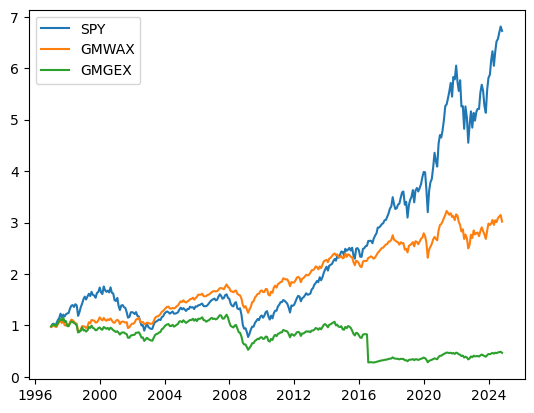

In [331]:
plt.plot(excess_df.index, (1+excess_df['SPY']).cumprod(), label='SPY')
plt.plot(excess_df.index, (1+excess_df['GMWAX']).cumprod(), label='GMWAX')
plt.plot(excess_df.index, (1+excess_df['GMGEX']).cumprod(), label='GMGEX')
plt.legend()
plt.show()

In [332]:
first_sample = excess_df.loc[:'2012']
second_sample = excess_df.loc['2012':]


In [333]:
def getStats(returns, annulization = 12):
    df = pd.DataFrame(index = returns.columns)
    df['Mean'] = returns.mean() * annulization
    df['Vol'] = returns.std() * np.sqrt(annulization)
    df['Sharpe'] = df['Mean'] / df['Vol']
    df['Skew'] = returns.skew()
    df['Kurtoisis'] = returns.kurt()
    df['Min Return'] = returns.min()
    df['VaR'] = returns.quantile(0.05) * np.sqrt(annulization)
    df['CVaR'] = returns[returns <= returns.quantile(0.05, axis = 0)].mean() * np.sqrt(annulization)
    cumret = (1+returns).cumprod()
    cumMax = cumret.cummax()
    drawdown = (cumret - cumMax) / cumMax
    df['Max DD'] = drawdown.min()
    df['Bottom'] = drawdown.idxmin()
    tops = []
    recovery = []
    for column in cumMax.columns:
        cMax = cumMax[column]
        cRet = cumret[column]
        bottom = df['Bottom'].loc[column]
        top = cMax[(cMax == cRet) & (cMax.index < bottom)].index[-1]
        tops.append(top)
        recovered = cRet[(cRet >= cRet.loc[top]) & (cRet.index > bottom)]
        if len(recovered) == 0:
            recovery.append(None)
        else:
            recovery.append(recovered.index[0])
    df['Top'] = tops
    df['Recovery'] = recovery
    return df

first_sample_stats = getStats(pd.DataFrame(first_sample['GMWAX']))
first_sample_stats

second_sample_stats = getStats(pd.DataFrame(second_sample['GMWAX']))
second_sample_stats

full_sample_stats = getStats(pd.DataFrame(excess_df['GMWAX']))
full_sample_stats

stats = pd.concat([first_sample_stats, second_sample_stats, full_sample_stats, getStats(pd.DataFrame(excess_df['SPY']))])
stats.index = ['first sample', 'second sample', 'full sample', 'SPY']
stats


/var/folders/n_/f68ys8cj3xxd01k82f007wbm0000gn/T/ipykernel_25676/765546166.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat([first_sample_stats, second_sample_stats, full_sample_stats, getStats(pd.DataFrame(excess_df['SPY']))])


,Mean,Vol,Sharpe,Skew,Kurtoisis,Min Return,VaR,CVaR,Max DD,Bottom,Top,Recovery
first sample,0.049823,0.108491,0.459236,-0.918858,3.176668,-0.149150,-0.152931,-0.256718,-0.306520,2009-02-27,2007-10-31,2010-12-31
second sample,0.043423,0.094949,0.457326,-0.507077,1.945528,-0.115018,-0.141524,-0.203890,-0.225613,2022-09-30,2021-05-31,NaT
full sample,0.045043,0.103490,0.435240,-0.758222,2.771186,-0.149150,-0.143302,-0.238499,-0.306520,2009-02-27,2007-10-31,2010-12-31
SPY,0.080499,0.154451,0.521198,-0.544056,0.769540,-0.165550,-0.275995,-0.344818,-0.559175,2009-02-27,2000-03-31,2013-03-29


In [334]:
def regress(returns, against, annulization = 52):
    against = against.copy()
    against = sm.add_constant(against)
    model = sm.OLS(returns, against).fit()
    r2 = model.rsquared
    alpha = model.params['const']
    tracking_error = model.resid.std()
    IR = alpha / tracking_error
    fitted_mean = model.fittedvalues.mean()
    sortino = returns.mean() / returns[returns < 0].std()
    stats = pd.DataFrame()
    stats['alpha'] = [alpha * annulization]
    betas = model.params.drop('const')
    for name, value in betas.items():
        stats[f"beta {name}"] = [value]
    treynors = None
    if len(betas) == 1:
        name = betas.keys()[0]
        treynors = (returns.mean() / model.params[name])
        stats['treynors'] = [treynors * annulization]
    else:
        stats['treynors'] = None
    stats['tracking error'] = [tracking_error]
    stats['IR'] = [IR * np.sqrt(annulization)]
    stats['sortino'] = [sortino * np.sqrt(annulization)]
    stats['R-Squared'] = [r2]
    return stats

first_sample_regression_stats = regress(first_sample['GMWAX'], first_sample['SPY'], annulization=12)
second_sample_regression_stats = regress(second_sample['GMWAX'], second_sample['SPY'], annulization=12)
full_sample_regression_stats = regress(excess_df['GMWAX'], excess_df['SPY'], annulization=12)

regression_stats = pd.concat([first_sample_regression_stats, second_sample_regression_stats, full_sample_regression_stats])
regression_stats.index = ['first sample', 'second sample', 'full sample']
regression_stats

,alpha,beta SPY,treynors,tracking error,IR,sortino,R-Squared
first sample,0.026321,0.544646,0.091478,0.018407,0.412782,0.574157,0.654569
second sample,-0.033960,0.581793,0.074636,0.013739,-0.713543,0.658023,0.748747
full sample,0.000558,0.552608,0.081510,0.016895,0.009542,0.573957,0.680167


In [335]:
gmgex_first_sample_regression_stats = regress(first_sample['GMGEX'], first_sample['SPY'], annulization=12)
gmgex_second_sample_regression_stats = regress(second_sample['GMGEX'], second_sample['SPY'], annulization=12)
gmgex_full_sample_regression_stats = regress(excess_df['GMGEX'], excess_df['SPY'], annulization=12)

gmgex_regression_stats = pd.concat([gmgex_first_sample_regression_stats, gmgex_second_sample_regression_stats, gmgex_full_sample_regression_stats])
gmgex_regression_stats.index = ['gmgex first sample', 'gmgex second sample', 'gmgex full sample']
gmgex_regression_stats

,alpha,beta SPY,treynors,tracking error,IR,sortino,R-Squared
gmgex first sample,-0.031363,0.772224,0.002538,0.021876,-0.413871,0.018535,0.729514
gmgex second sample,-0.110164,0.838118,0.001564,0.058792,-0.540923,0.004641,0.252468
gmgex full sample,-0.064790,0.786683,-0.001860,0.043147,-0.433477,-0.007213,0.397891


In [336]:
signals = pd.read_excel("../data/gmo_data.xlsx", sheet_name='signals', parse_dates=['date']).set_index('date')

signals

,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.4180
1997-01-31,1.8455,20.8856,6.4940
1997-02-28,1.8502,21.0116,6.5520
1997-03-31,1.9427,18.4633,6.9030
1997-04-30,1.8430,19.6004,6.7180
...,...,...,...
2024-06-28,1.3271,25.5386,4.3961
2024-07-31,1.3205,25.7965,4.0296
2024-08-30,1.2990,25.5680,3.9034


In [337]:
signals = signals.shift().fillna(0)



dp_reg = regress(df['SPY'], signals['SPX DVD YLD'], annulization=12)
ep_reg = regress(df['SPY'], signals['SPX P/E'], annulization=12)
multi_reg = regress(df['SPY'], signals, annulization=12)

gmgex_regression_stats = pd.concat([gmgex_first_sample_regression_stats, gmgex_second_sample_regression_stats, gmgex_full_sample_regression_stats])
gmgex_regression_stats.index = ['gmgex first sample', 'gmgex second sample', 'gmgex full sample']
gmgex_regression_stats

regressions = pd.concat([dp_reg, ep_reg, multi_reg])
regressions.index = ['Div to Price Ratio', 'PE ratio', 'All three']
regressions

/var/folders/n_/f68ys8cj3xxd01k82f007wbm0000gn/T/ipykernel_25676/221190515.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regressions = pd.concat([dp_reg, ep_reg, multi_reg])


,alpha,beta SPX DVD YLD,treynors,tracking error,IR,sortino,R-Squared,beta SPX P/E,beta TNote 10YR
Div to Price Ratio,-0.141015,0.011192,9.119604,0.044325,-0.918382,0.929981,0.010723,NaN,NaN
PE ratio,0.223161,NaN,-199.354252,0.044507,1.447437,0.929981,0.002602,-0.000512,NaN
All three,-0.222697,0.012613,NaN,0.044305,-1.451018,0.929981,0.011641,0.000326,-0.000625


In [338]:
def getRegression(returns, against):
    against = against.copy()
    against = sm.add_constant(against)
    model = sm.OLS(returns, against).fit()
    return model


dp_reg = getRegression(excess_df['SPY'], signals['SPX DVD YLD'])
ep_reg = getRegression(excess_df['SPY'], signals['SPX P/E'])
multi_reg = getRegression(excess_df['SPY'], signals)
dp_reg

In [339]:
# note the signals dataframe has already been shifted
position = pd.DataFrame(index = signals.index, columns=['DP', 'PE', 'All Three'])

for index in position.index:
    position.loc[index, 'DP'] = 100 * dp_reg.predict([1, signals.loc[index, 'SPX DVD YLD']])
    position.loc[index, 'PE'] = 100 * ep_reg.predict([1, signals.loc[index, 'SPX P/E']])
    position.loc[index, 'All Three'] = 100 * multi_reg.predict([1, *signals.loc[index]])
    
position.iloc[0] = [0,0,0]
position

,DP,PE,All Three
date,,,
1996-12-31,0,0,0
1997-01-31,0.8805637898723786,0.672386410599921,0.4742075230975227
1997-02-28,0.7188579199733129,0.5942440052515372,0.3381283353562806
1997-03-31,0.7252125820847313,0.5860274125169161,0.3408204876902666
1997-04-30,0.8502777406605134,0.7522047400219536,0.3321587256386541
...,...,...,...
2024-06-28,0.06662621730350399,0.34899827543913514,0.07789847444727681
2024-07-31,0.017952209641577902,0.29081697355160463,0.07299586320730841
2024-08-30,0.009028641570224876,0.2739990428670111,0.12453938945424688


In [340]:
returns = pd.DataFrame(index = signals.index, columns = position.columns)


returns = position.multiply(excess_df['SPY'], axis=0)
ret_stats = getStats(returns, annulization=12)
ret_stats


,Mean,Vol,Sharpe,Skew,Kurtoisis,Min Return,VaR,CVaR,Max DD,Bottom,Top,Recovery
DP,0.089431,0.167023,0.535437,-0.088469,16.257843,-0.3046,-0.170354,-0.374183,-0.729836,2009-02-27,2007-10-31,2012-02-29
PE,0.065968,0.115838,0.569483,-0.463457,3.63444,-0.161049,-0.167851,-0.271338,-0.524754,2009-02-27,2007-10-31,2012-03-30
All Three,0.094978,0.167827,0.56593,0.156364,13.588872,-0.288222,-0.156825,-0.371917,-0.689414,2009-02-27,2007-10-31,2011-01-31


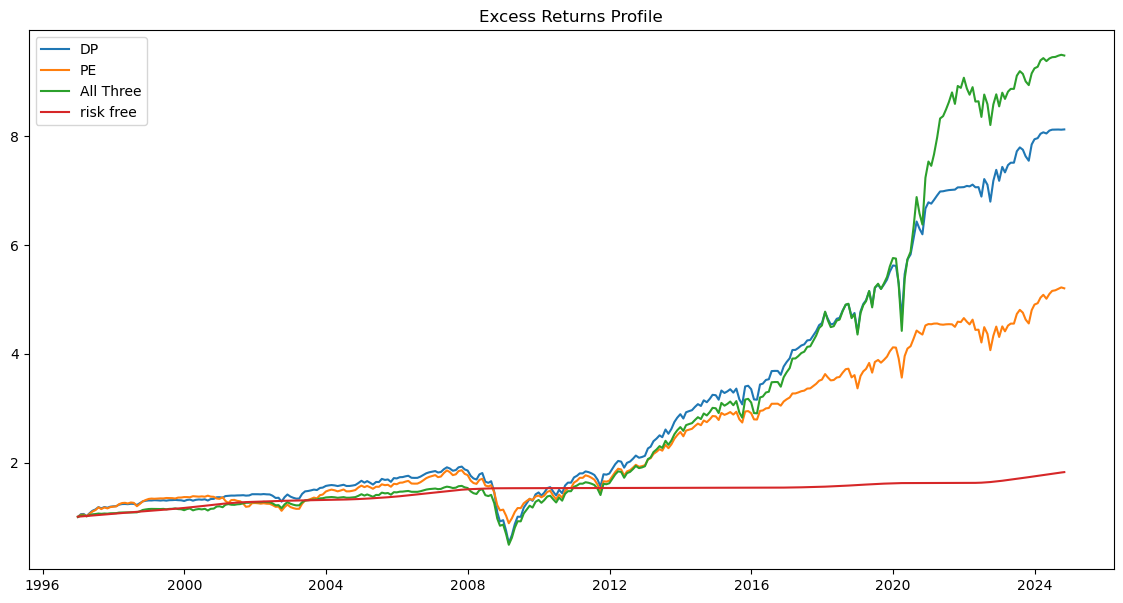

In [341]:
plt.figure(figsize=(14, 7))

for column in returns.columns:
    plt.plot(returns.index, (1+returns[column]).cumprod(), label = column)

plt.plot(returns.index, (1+risk_free.loc[returns.index]).cumprod(), label = 'risk free')
plt.title('Excess Returns Profile')
plt.legend()
plt.show()


In [342]:
for column in returns.columns:
    aligned_risk_free = risk_free.loc[position.index]


    condition = (position[column] / 100) < 0
    

    under_performance = position[column][condition].count()

    print(f"{column} was predicted to under performed the risk free {under_performance} out of {len(position)} months")


DP was predicted to under performed the risk free 36 out of 335 months
PE was predicted to under performed the risk free 3 out of 335 months
All Three was predicted to under performed the risk free 36 out of 335 months


In [343]:
x_train, x_test = signals.iloc[:60], signals.iloc[60:]
y_train, y_test = df.iloc[:60], df.iloc[60:]

def getRegression(returns, against):
    against = against.copy()
    against = sm.add_constant(against)
    model = sm.OLS(returns, against).fit()
    return model


dp_reg = getRegression(y_train['SPY'], x_train['SPX DVD YLD'])
ep_reg = getRegression(y_train['SPY'], x_train['SPX P/E'])
multi_reg = getRegression(y_train['SPY'], x_train)
dp_reg

In [344]:
position = pd.DataFrame(index = signals.iloc[60:].index, columns=['DP', 'PE', 'All Three'])

for index in position.index:
    past_index = signals.index.get_loc(index) - 1  
    if past_index < 0:
        continue
    past_date = signals.index[past_index]

    dp_reg = getRegression(excess_df['SPY'].loc[: past_date], signals['SPX DVD YLD'].loc[: past_date])
    ep_reg = getRegression(excess_df['SPY'].loc[: past_date], signals['SPX P/E'].loc[: past_date])
    multi_reg = getRegression(excess_df['SPY'].loc[: past_date], signals.loc[: past_date])
    position.loc[index, 'DP'] = 100 * dp_reg.predict([1, signals.loc[index, 'SPX DVD YLD']])
    position.loc[index, 'PE'] = 100 * ep_reg.predict([1, signals.loc[index, 'SPX P/E']])
    position.loc[index, 'All Three'] = 100 * multi_reg.predict([1, *signals.loc[index]])
    
position.iloc[0] = [0,0,0]
position

,DP,PE,All Three
date,,,
2001-12-31,0,0,0
2002-01-31,0.48518734445509454,0.4036348356560719,1.037399246722305
2002-02-28,0.5808791612578438,0.33333868792488763,1.1539433317614847
2002-03-29,0.7086854289979769,0.14929281766973185,1.3929773560632261
2002-04-30,0.49981923040426796,0.13971098703211307,0.7426175629428405
...,...,...,...
2024-06-28,0.023968176208948665,0.3148086532549417,0.03228310183115424
2024-07-31,-0.005214263351844931,0.2741766963979614,0.04900492122290184
2024-08-30,-0.008647740105389738,0.26116369205155615,0.10640747057670749


In [345]:
returns = pd.DataFrame(index = signals.index, columns = position.columns)


returns = position.multiply(y_test['SPY'], axis=0)
ret_stats = getStats(returns, annulization=12)
ret_stats

,Mean,Vol,Sharpe,Skew,Kurtoisis,Min Return,VaR,CVaR,Max DD,Bottom,Top,Recovery
DP,0.065053,0.15438,0.421383,-1.150854,8.492964,-0.25765,-0.185211,-0.40777,-0.6371,2009-04-30,2007-10-31,2018-07-31
PE,0.061684,0.093282,0.661257,-0.293986,1.905212,-0.114416,-0.137411,-0.203011,-0.365185,2009-03-31,2007-10-31,2013-10-31
All Three,0.049128,0.161924,0.303401,-1.406693,9.050449,-0.285884,-0.185353,-0.443149,-0.594288,2012-05-31,2007-10-31,2021-03-31


In [346]:
oos_mean_spy = y_test['SPY'].mean()

oos_forecast_error = pd.DataFrame(index=y_test.index, columns=position.columns)
oos_forecast_error = y_test['SPY'].values.reshape(-1, 1) - (position / 100)

oos_null_error = y_test['SPY'].values.reshape(-1, 1) - oos_mean_spy


R2 = {}
for column in position.columns:
    R2[column] = 1 - (oos_forecast_error[column]**2).sum() / (oos_null_error**2).sum()


print(R2)


{'DP': -0.03538524845980251, 'PE': -0.009932459998183818, 'All Three': -0.05564531025505137}


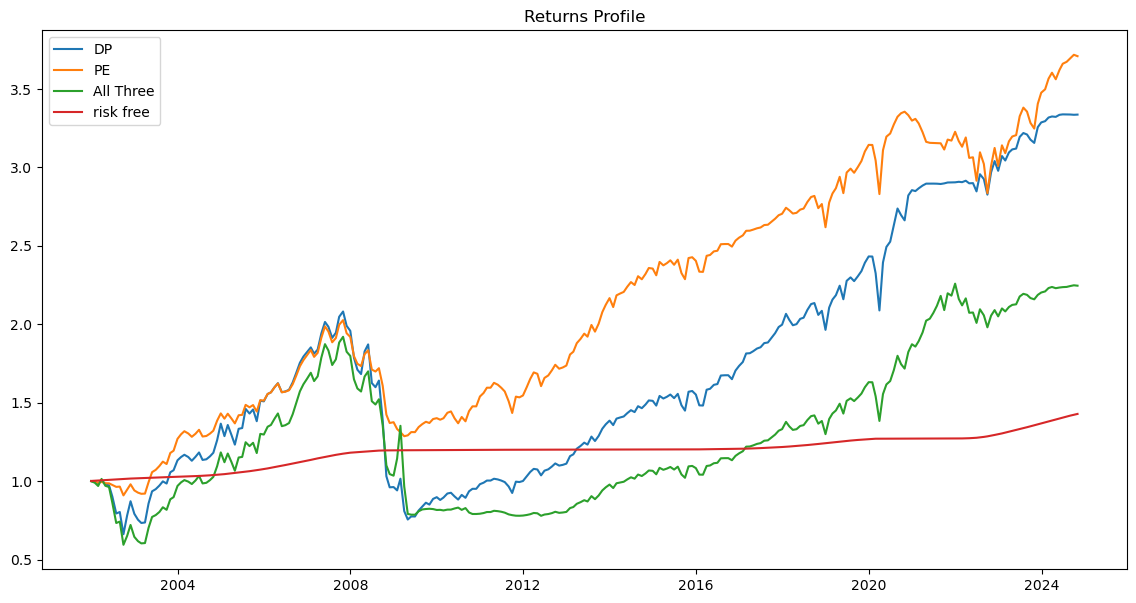

In [347]:

plt.figure(figsize=(14, 7))

for column in returns.columns:
    plt.plot(returns.index, (1+returns[column]).cumprod(), label = column)

plt.plot(returns.index, (1+risk_free.loc[returns.index]).cumprod(), label = 'risk free')
plt.title('Returns Profile')
plt.legend()
plt.show()





In [348]:
for column in returns.columns:
    aligned_risk_free = risk_free.loc[position.index]


    condition = (position[column] / 100) < aligned_risk_free['TBill 3M']
    

    under_performance = position[column][condition].count()

    print(f"{column} was predicted to under performed the risk free {under_performance} out of {len(position)} months")

    

DP was predicted to under performed the risk free 32 out of 275 months
PE was predicted to under performed the risk free 27 out of 275 months
All Three was predicted to under performed the risk free 43 out of 275 months
